# House Prices - Advanced Regression Techniques
#### Author: James Coffey
#### Date: 5/22/2025
#### Challenge URL: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# Business Understanding

> **Goal:** Align on the problem, success metrics, and constraints before touching any data.

* **What** exactly is the business question or problem we’re solving?
* **Who** are the stakeholders and end-users, and what decisions will they make from our work?
* **How** will success be measured (revenue lift, error reduction, user engagement, etc.)?
* **What** are the timeline, budget, technical or regulatory constraints?

# Data Acquisition

> **Goal:** Identify, access, and gather all relevant raw data.

* **Which** data sources—databases, APIs, third-party feeds, flat files, user logs—are needed?
* **Is** the historical coverage and granularity sufficient for modeling?
* **How** do we authenticate, extract, and securely store that data?
* **What** metadata (schema definitions, data dictionaries) do we need to collect as well?

# Imports & Settings

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
try:
    from optuna.integration import TFKerasPruningCallback
except ImportError:
    import subprocess, sys
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", "optuna-integration[tfkeras]"
    ])
    from optuna.integration import TFKerasPruningCallback
from optuna.pruners import HyperbandPruner
from optuna.samplers import GridSampler, RandomSampler
import os
import pandas as pd
import seaborn as sns
import shap
from sklearn.impute    import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose      import ColumnTransformer
from sklearn.pipeline     import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import (
    LinearRegression, RidgeCV, LassoCV, ElasticNetCV
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import (
    ExponentialDecay,
    InverseTimeDecay,
    PiecewiseConstantDecay,
    CosineDecay
)
import warnings
import xgboost as xgb
import ydf

# Comment this if the data visualisations do not work
%matplotlib inline

# Keep the notebook clean
warnings.filterwarnings("ignore", category=FutureWarning)

# Use IS_INTERACTIVE to flag models / code not to run for Kaggle submission

IS_INTERACTIVE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") == "Interactive"

2025-05-24 16:56:13.805262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748105773.834124     762 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748105773.842442     762 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Ingestion & Loading

> **Goal:** Bring raw data into your working environment in a consistent, queryable form.

* **What** formats (CSV, JSON, Parquet, SQL tables) and partitioning schemes will you use?
* **How** will you version and document each data snapshot?
* **Are** there schema mismatches or encoding issues to resolve on ingestion?

In [ ]:
base_path = "/kaggle/input/house-prices-advanced-regression-techniques"
train = pd.read_csv(base_path + "/train.csv")
desc  = pd.read_csv(
    base_path + "/data_description.txt",
    sep=":",
    names=["Variable","Description"],
    comment="#",
    engine="python",
)

## Glance at the data dictionary

In [ ]:
desc.head()

,Variable,Description
0,MSSubClass,Identifies the type of dwelling involved in t...
1,20\t1-STORY 1946 & NEWER ALL STYLES,None
2,30\t1-STORY 1945 & OLDER,None
3,40\t1-STORY W/FINISHED ATTIC ALL AGES,None
4,45\t1-1/2 STORY - UNFINISHED ALL AGES,None


## Quick look at the shape

In [ ]:
print(f"Train shape: {train.shape}")

Train shape: (1460, 81)


## Peek at the first 5 rows

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Drop `Id` column

`Id` isn't needed for model training.

In [ ]:
train = train.drop('Id', axis=1)
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Data types & non-null counts

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Data Cleaning & Preprocessing

> **Goal:** Fix quality issues so that analyses and models aren’t led astray.

* **Which** records are duplicates or obviously erroneous?
* **How** will we handle missing values—delete, impute (mean, median, domain logic), or flag?
* **What** outlier-detection rules or domain thresholds should we apply?
* **Are** categorical fields consistent (e.g. “NY” vs “New York”)?

## Check missing values

In [ ]:
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

# Exploratory Data Analysis (EDA)

> **Goal:** Uncover patterns, spot anomalies, test assumptions—without yet building models.

* **What** are the distributions of key variables (histograms, boxplots)?
* **Which** variables correlate strongly or show multicollinearity?
* **Are** there non-linear relationships, seasonal trends, or segmentable clusters?
* **Do** any initial hypotheses about drivers of the target variable hold up?

## Summary stats for numeric features

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


## Inspect categorical features

In [ ]:
cat_cols = train.select_dtypes(include="object").columns

for col in cat_cols:
    print(f"\n=== {col} ({train[col].nunique()} levels) ===")
    print(train[col].value_counts(dropna=False).head(10))


=== MSZoning (5 levels) ===
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

=== Street (2 levels) ===
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

=== Alley (2 levels) ===
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64

=== LotShape (4 levels) ===
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

=== LandContour (4 levels) ===
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

=== Utilities (2 levels) ===
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

=== LotConfig (5 levels) ===
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

=== LandSlope (3 levels) ===
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

=== Neighborhood (25 levels) ===
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    

## House price distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


The figure layout has changed to tight


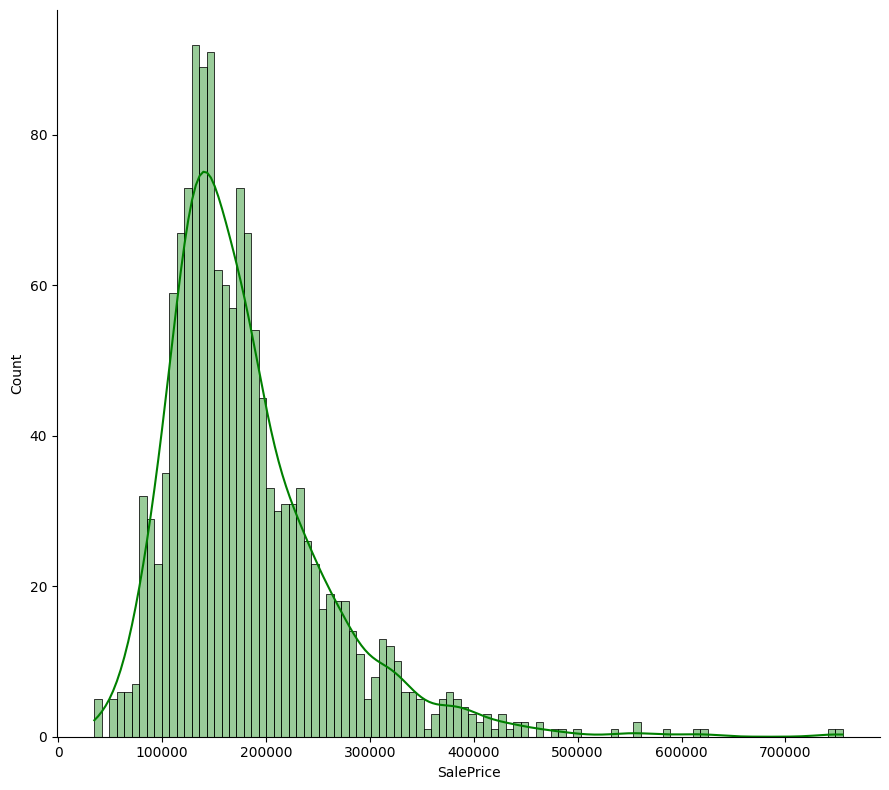

In [ ]:
print(train["SalePrice"].describe())

sns.displot(
    data=train,
    x="SalePrice",
    kind="hist",         # you can also use kind="kde" or kind="ecdf"
    bins=100,
    color="g",
    alpha=0.4,
    kde=True,            # only works when kind="hist"
    height=8,
    aspect=9/8           # width = aspect × height
)

## Numeric data distribution

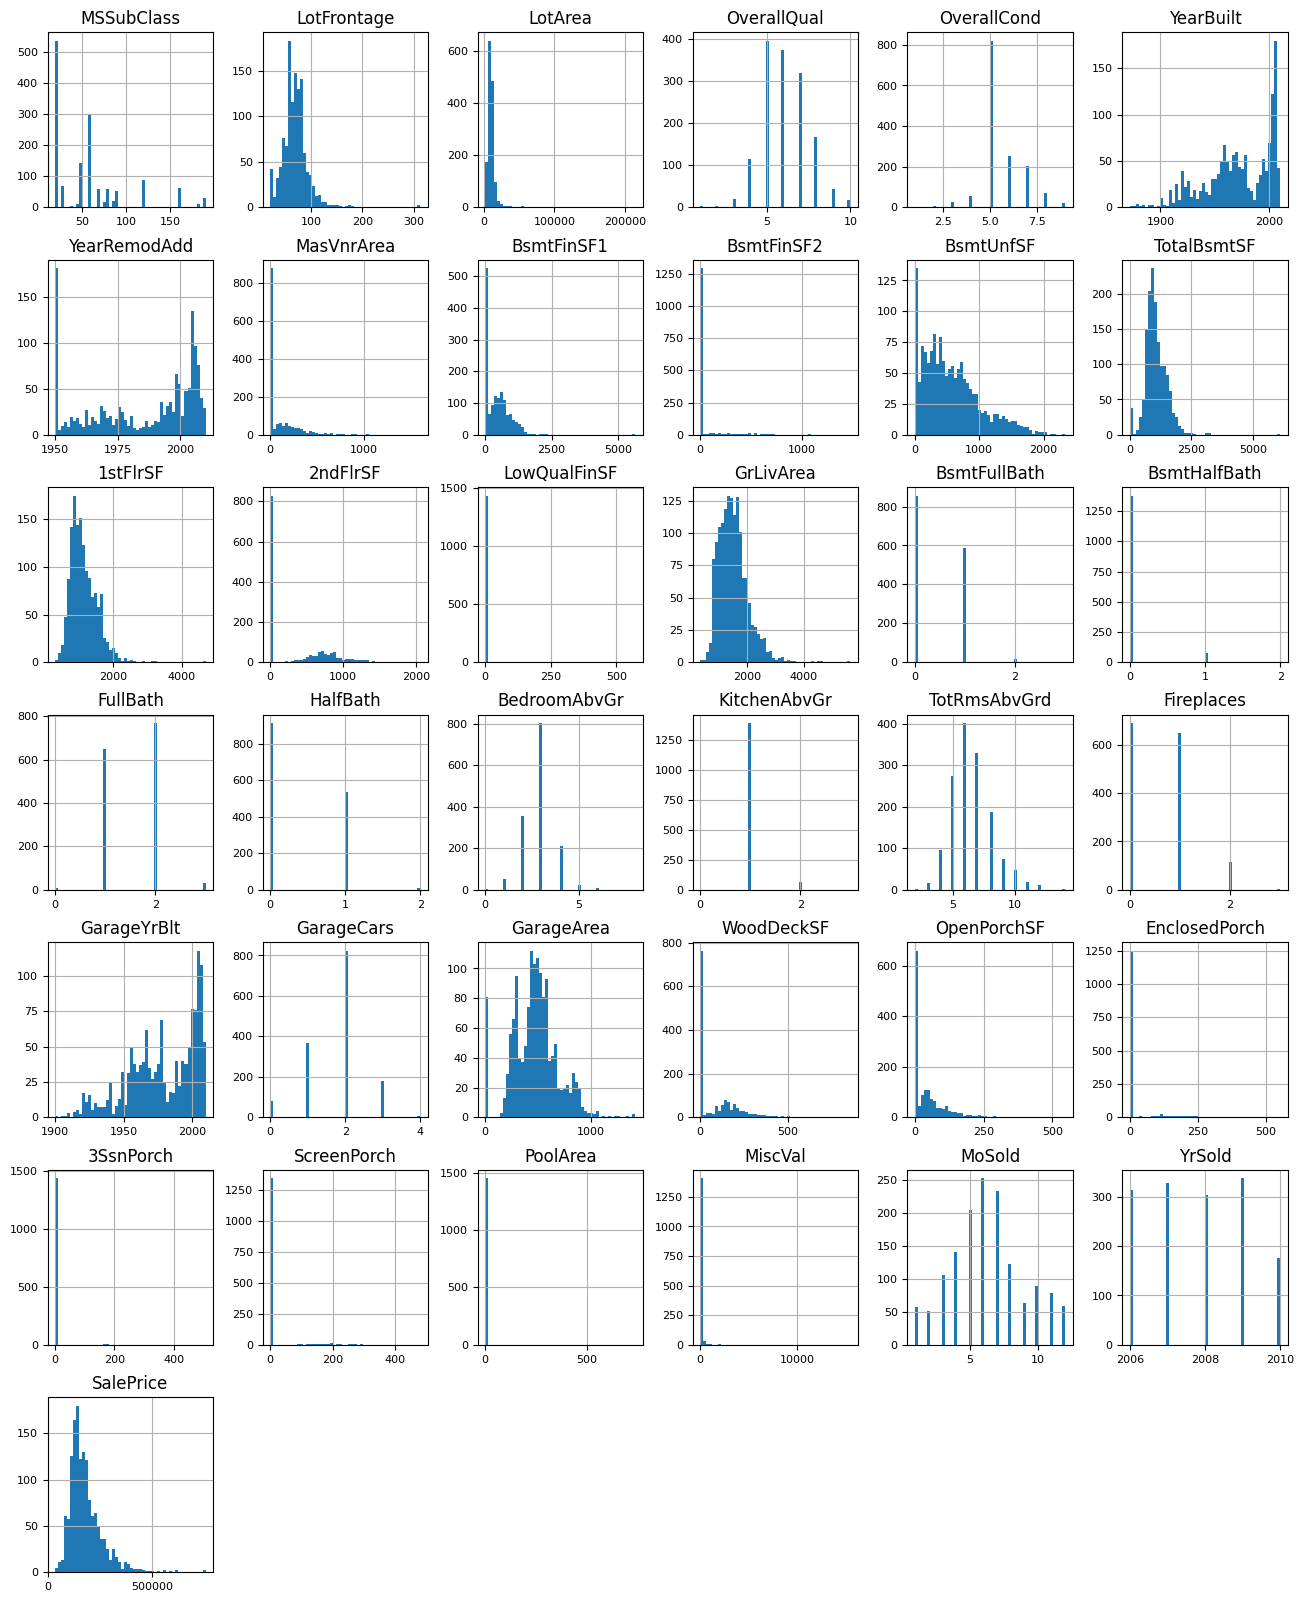

In [ ]:
train \
    .select_dtypes(
        include=['float64', 'int64']
    ) \
    .hist(
        figsize=(16, 20),
        bins=50,
        xlabelsize=8,
        ylabelsize=8
    );

# Feature Engineering & Selection

> **Goal:** Transform raw inputs into signal-rich features, and pick the ones most predictive.

* **What** new features can we derive (date-parts, ratios, text embeddings)?
* **How** do we encode categorical variables (one-hot, target encoding, embeddings)?
* **Which** features add real predictive power vs. noise?
* **Should** we apply dimensionality reduction (PCA, LDA) or feature-selection algorithms?

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

## Pipeline Development

In [ ]:
def make_preprocessor(
    df,
    test_size=0.2,
    random_state=42,
    scale_numeric=False
):
    # 1) Split
    X = df.drop("SalePrice", axis=1)
    y = df["SalePrice"]
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 2) Identify column types
    num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    # 3) Numeric pipeline: median impute + optional scale
    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))
    numeric_pipeline = Pipeline(num_steps)

    # 4) Categorical pipeline: fill MISSING + one-hot
    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

    # 5) Combine
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ])

    # 6) Fit & transform
    X_train_prep = preprocessor.fit_transform(X_train)
    X_valid_prep = preprocessor.transform(X_valid)

    # 7) Grab feature names to rebuild DataFrames for YDF
    feat_names = []
    # numeric names stay the same
    feat_names += num_cols
    # categorical names from one-hot
    cat_names = preprocessor \
        .named_transformers_["cat"] \
        .named_steps["onehot"] \
        .get_feature_names_out(cat_cols)
    feat_names += cat_names.tolist()

    # 8) Scale y
    y_train = np.log1p(y_train)
    y_valid = np.log1p(y_valid)

    # 9) Build DataFrames for YDF learners
    df_train_ydf = pd.DataFrame(X_train_prep, columns=feat_names)
    df_train_ydf["SalePrice"] = y_train.reset_index(drop=True)
    df_valid_ydf = pd.DataFrame(X_valid_prep, columns=feat_names)
    df_valid_ydf["SalePrice"] = y_valid.reset_index(drop=True)

    return (
        X_train_prep,
        X_valid_prep,
        y_train,
        y_valid,
        df_train_ydf,
        df_valid_ydf,
        preprocessor
    )

### For linear, YDF tree, and XGBoost models

In [ ]:
X_train, X_valid, y_train, y_valid,\
df_train_ydf, df_valid_ydf, preprocessor = make_preprocessor(train)

### For Keras MLP

In [ ]:
X_train_mlp, X_valid_mlp, _, _, _, _, _ = make_preprocessor(train, scale_numeric=True)

# Model Training & Tuning

> **Goal:** Fit candidate algorithms and optimize them on your training data.

* **What** modeling families make sense (linear, tree-based, neural nets, clustering)?
* **Which** hyperparameters will we tune, and what search strategy (grid, random, Bayesian)?
* **How** will we split our data (hold-out set, k-fold cross-validation, time series CV)?
* **Are** computation and inference time within acceptable limits?

## Model selection

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

## Linear Models

### Unregularized linear regression / ordinary least squares

In [ ]:
if IS_INTERACTIVE:
    lr = LinearRegression(fit_intercept=True, n_jobs=-1)
    lr.fit(X_train, y_train)

### Ridge (Grid via RidgeCV)

In [ ]:
if IS_INTERACTIVE:
    ridge_alphas = np.logspace(-3, 3, 13)
    ridge = RidgeCV(alphas=ridge_alphas, store_cv_values=True)
    ridge.fit(X_train, y_train)
    print("Ridge     α* =", ridge.alpha_)

Ridge     α* = 31.622776601683793


### Lasso (built-in LassoCV)

In [ ]:
if IS_INTERACTIVE:
    lasso_alphas = np.logspace(-4, 0, 50)
    lasso = LassoCV(alphas=lasso_alphas, cv=5, n_jobs=-1, max_iter=5000)
    lasso.fit(X_train, y_train)
    print("Lasso     α* =", lasso.alpha_)

Lasso     α* = 0.0007906043210907702


### ElasticNet (ElasticNetCV)

In [ ]:
if IS_INTERACTIVE:
    en_alpha    = np.logspace(-4, 0, 30)
    en_l1_ratio = np.linspace(0.1, 0.9, 9)
    enet = ElasticNetCV(
        alphas=en_alpha,
        l1_ratio=en_l1_ratio,
        cv=5,
        n_jobs=-1,
        max_iter=5000
    )
    enet.fit(X_train, y_train)
    print("ElasticNet α*, l1_ratio* =", enet.alpha_, enet.l1_ratio_)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3653490311578493, tolerance: 0.014284637439676187
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1914444571961318, tolerance: 0.013347420950409507
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2888153206570476, tolerance: 0.014284637439676187
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2220424631029112, tolerance: 0.014284637439676187
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.328343663447991, tolerance: 0.014284637439676187
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2512977040063245, tolerance: 0.014284637439676187
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1638205534027501, tolerance: 

ElasticNet α*, l1_ratio* = 0.004520353656360241 0.1


## Tree-based models

### Classification and regression trees (CART) - Single Decision Tree

In [ ]:
def cart_objective(trial):
    max_depth    = trial.suggest_categorical("max_depth", [3, 5, 10, 15, None])
    min_examples = trial.suggest_categorical("min_examples", [1, 5, 10, 20])
    model = (
        ydf.CartLearner(
            label="SalePrice",
            task=ydf.Task.REGRESSION,
            max_depth=max_depth,
            min_examples=min_examples
        )
        .train(df_train_ydf)
    )
    preds = model.predict(df_valid_ydf)
    return mean_squared_error(y_valid, preds, squared=False)

if IS_INTERACTIVE:
    # Define the full grid
    cart_search_space = {
        "max_depth":    [3, 5, 10, 15, None],
        "min_examples": [1, 5, 10, 20],
    }
    cart_sampler = GridSampler(cart_search_space)
    study_cart = optuna.create_study(
        direction="minimize",
        sampler=cart_sampler
    )
    # n_trials = len(max_depth) x len (min_examples) = 5 × 4 = 20
    study_cart.optimize(cart_objective, n_trials=20)

    print("CART best params:", study_cart.best_params)

[I 2025-05-24 16:56:48,416] A new study created in memory with name: no-name-ab08d37f-6185-49ea-89d5-407be5f06e6d


Train model on 1168 examples
Model trained in 0:00:00.050787


[I 2025-05-24 16:56:48,544] Trial 0 finished with value: 0.19411536432539567 and parameters: {'max_depth': None, 'min_examples': 10}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.016008


[I 2025-05-24 16:56:48,622] Trial 1 finished with value: 0.26487277916831775 and parameters: {'max_depth': 3, 'min_examples': 5}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.040781


[I 2025-05-24 16:56:48,719] Trial 2 finished with value: 0.20462515309218132 and parameters: {'max_depth': None, 'min_examples': 20}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.056323


[I 2025-05-24 16:56:48,835] Trial 3 finished with value: 0.19870286868703158 and parameters: {'max_depth': 10, 'min_examples': 1}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.044957


[I 2025-05-24 16:56:48,946] Trial 4 finished with value: 0.19411536432539567 and parameters: {'max_depth': 10, 'min_examples': 10}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.058121


[I 2025-05-24 16:56:49,063] Trial 5 finished with value: 0.19648983112353385 and parameters: {'max_depth': None, 'min_examples': 5}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.027635


[I 2025-05-24 16:56:49,148] Trial 6 finished with value: 0.2162308989877055 and parameters: {'max_depth': 5, 'min_examples': 10}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.058404


[I 2025-05-24 16:56:49,263] Trial 7 finished with value: 0.19648983112353385 and parameters: {'max_depth': 15, 'min_examples': 5}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.026997


[I 2025-05-24 16:56:49,348] Trial 8 finished with value: 0.2162308989877055 and parameters: {'max_depth': 5, 'min_examples': 1}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.016291


[I 2025-05-24 16:56:49,423] Trial 9 finished with value: 0.26487277916831775 and parameters: {'max_depth': 3, 'min_examples': 10}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.028566


[I 2025-05-24 16:56:49,512] Trial 10 finished with value: 0.2162308989877055 and parameters: {'max_depth': 5, 'min_examples': 5}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.048271


[I 2025-05-24 16:56:49,619] Trial 11 finished with value: 0.19411536432539567 and parameters: {'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.050556


[I 2025-05-24 16:56:49,727] Trial 12 finished with value: 0.2016693251515373 and parameters: {'max_depth': 10, 'min_examples': 5}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.026845


[I 2025-05-24 16:56:49,812] Trial 13 finished with value: 0.2162308989877055 and parameters: {'max_depth': 5, 'min_examples': 20}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.101526


[I 2025-05-24 16:56:49,972] Trial 14 finished with value: 0.2085157684069669 and parameters: {'max_depth': None, 'min_examples': 1}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.040833


[I 2025-05-24 16:56:50,070] Trial 15 finished with value: 0.20462515309218132 and parameters: {'max_depth': 10, 'min_examples': 20}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.016240


[I 2025-05-24 16:56:50,142] Trial 16 finished with value: 0.26487277916831775 and parameters: {'max_depth': 3, 'min_examples': 20}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.016196


[I 2025-05-24 16:56:50,215] Trial 17 finished with value: 0.26487277916831775 and parameters: {'max_depth': 3, 'min_examples': 1}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.039699


[I 2025-05-24 16:56:50,312] Trial 18 finished with value: 0.20462515309218132 and parameters: {'max_depth': 15, 'min_examples': 20}. Best is trial 0 with value: 0.19411536432539567.


Train model on 1168 examples
Model trained in 0:00:00.095978


[I 2025-05-24 16:56:50,469] Trial 19 finished with value: 0.1959106277777739 and parameters: {'max_depth': 15, 'min_examples': 1}. Best is trial 0 with value: 0.19411536432539567.


CART best params: {'max_depth': None, 'min_examples': 10}


### Ensemble methods

#### Bagging

##### Random forest

In [ ]:
def rf_objective(trial):
    params = {
        "num_trees":     trial.suggest_categorical("num_trees", [100, 500, 1000]),
        "max_depth":     trial.suggest_categorical("max_depth", [None, 10, 20, 30]),
        "num_candidate_attributes_ratio": trial.suggest_categorical(
            "num_candidate_attributes_ratio", [0.3, 0.5, 0.7, 1.0]
        ),
        "min_examples":  trial.suggest_categorical("min_examples", [1, 5, 10, 20]),
    }
    model = (
        ydf.RandomForestLearner(
            label="SalePrice",
            task=ydf.Task.REGRESSION,
            compute_oob_performances=True,
            **params
        )
        .train(df_train_ydf)
    )
    preds = model.predict(df_valid_ydf)
    return mean_squared_error(y_valid, preds, squared=False)

if IS_INTERACTIVE:
    rf_sampler = RandomSampler(seed=42)
    study_rf = optuna.create_study(
        direction="minimize",
        sampler=rf_sampler
    )
    study_rf.optimize(rf_objective, n_trials=50)

    print("RF    best params:", study_rf.best_params)

[I 2025-05-24 16:56:50,478] A new study created in memory with name: no-name-c206abbd-7b57-4f7c-b7f2-040f086bcbdb


Train model on 1168 examples
Model trained in 0:00:15.203275


[I 2025-05-24 16:57:06,174] Trial 0 finished with value: 0.14486238351007494 and parameters: {'num_trees': 500, 'max_depth': None, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:19.756113


[I 2025-05-24 16:57:26,116] Trial 1 finished with value: 0.15358613451291678 and parameters: {'num_trees': 1000, 'max_depth': 20, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:01.818638


[I 2025-05-24 16:57:28,003] Trial 2 finished with value: 0.15452043076221275 and parameters: {'num_trees': 100, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:01.379509


[I 2025-05-24 16:57:29,444] Trial 3 finished with value: 0.16448135591411214 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:19.535014


[I 2025-05-24 16:57:49,172] Trial 4 finished with value: 0.15347583489557493 and parameters: {'num_trees': 1000, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:07.803617


[I 2025-05-24 16:57:57,098] Trial 5 finished with value: 0.15320759294567213 and parameters: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:13.687378


[I 2025-05-24 16:58:10,912] Trial 6 finished with value: 0.16232276552642244 and parameters: {'num_trees': 1000, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:16.335210


[I 2025-05-24 16:58:27,444] Trial 7 finished with value: 0.15306229851465142 and parameters: {'num_trees': 1000, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:06.903096


[I 2025-05-24 16:58:34,439] Trial 8 finished with value: 0.16253737989458117 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:13.648792


[I 2025-05-24 16:58:48,467] Trial 9 finished with value: 0.14915099672780688 and parameters: {'num_trees': 1000, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:01.530031


[I 2025-05-24 16:58:50,069] Trial 10 finished with value: 0.14826468652584393 and parameters: {'num_trees': 100, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:02.111617


[I 2025-05-24 16:58:52,264] Trial 11 finished with value: 0.1549823787185443 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:19.240011


[I 2025-05-24 16:59:11,823] Trial 12 finished with value: 0.1479844702937934 and parameters: {'num_trees': 1000, 'max_depth': None, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:22.953339


[I 2025-05-24 16:59:35,657] Trial 13 finished with value: 0.14737357385531366 and parameters: {'num_trees': 1000, 'max_depth': None, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:10.890913


[I 2025-05-24 16:59:46,773] Trial 14 finished with value: 0.14651584824709082 and parameters: {'num_trees': 500, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:09.588927


[I 2025-05-24 16:59:56,490] Trial 15 finished with value: 0.1535926236587692 and parameters: {'num_trees': 500, 'max_depth': None, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:10.284212


[I 2025-05-24 17:00:06,964] Trial 16 finished with value: 0.14730441855767676 and parameters: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:12.060105


[I 2025-05-24 17:00:19,214] Trial 17 finished with value: 0.14757086498303076 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:16.561738


[I 2025-05-24 17:00:35,903] Trial 18 finished with value: 0.16227475248375 and parameters: {'num_trees': 1000, 'max_depth': None, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:13.728296


[I 2025-05-24 17:00:50,003] Trial 19 finished with value: 0.14915099672780688 and parameters: {'num_trees': 1000, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:18.773745


[I 2025-05-24 17:01:08,966] Trial 20 finished with value: 0.15326551741974448 and parameters: {'num_trees': 1000, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:02.346829


[I 2025-05-24 17:01:11,392] Trial 21 finished with value: 0.14902251112698764 and parameters: {'num_trees': 100, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 5}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:16.676295


[I 2025-05-24 17:01:28,600] Trial 22 finished with value: 0.14492127805008417 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:07.999441


[I 2025-05-24 17:01:36,731] Trial 23 finished with value: 0.15320759294567213 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:08.218021


[I 2025-05-24 17:01:45,071] Trial 24 finished with value: 0.15320759294567213 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:07.636143


[I 2025-05-24 17:01:52,796] Trial 25 finished with value: 0.1620739087456032 and parameters: {'num_trees': 500, 'max_depth': None, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:04.034310


[I 2025-05-24 17:01:56,980] Trial 26 finished with value: 0.14809800566474768 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:01.464052


[I 2025-05-24 17:01:58,505] Trial 27 finished with value: 0.16448135591411214 and parameters: {'num_trees': 100, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:03.246992


[I 2025-05-24 17:02:01,904] Trial 28 finished with value: 0.14735323524085245 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:43.456112


[I 2025-05-24 17:02:46,369] Trial 29 finished with value: 0.14607808769094274 and parameters: {'num_trees': 1000, 'max_depth': 30, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 1}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:01.639786


[I 2025-05-24 17:02:48,073] Trial 30 finished with value: 0.16448135591411214 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 20}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:18.796551


[I 2025-05-24 17:03:07,059] Trial 31 finished with value: 0.15358613451291678 and parameters: {'num_trees': 1000, 'max_depth': 30, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 10}. Best is trial 0 with value: 0.14486238351007494.


Train model on 1168 examples
Model trained in 0:00:19.822509


[I 2025-05-24 17:03:27,413] Trial 32 finished with value: 0.14467349938826626 and parameters: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 1}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:08.564253


[I 2025-05-24 17:03:36,094] Trial 33 finished with value: 0.15346944809346025 and parameters: {'num_trees': 500, 'max_depth': 10, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 10}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:22.750694


[I 2025-05-24 17:03:59,159] Trial 34 finished with value: 0.14737357385531366 and parameters: {'num_trees': 1000, 'max_depth': None, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 5}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:03.338567


[I 2025-05-24 17:04:02,652] Trial 35 finished with value: 0.14514674446960144 and parameters: {'num_trees': 100, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:01.601077


[I 2025-05-24 17:04:04,316] Trial 36 finished with value: 0.16312307938260495 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 20}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:01.884356


[I 2025-05-24 17:04:06,267] Trial 37 finished with value: 0.1549157811931987 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 10}. Best is trial 32 with value: 0.14467349938826626.


Train model on 1168 examples
Model trained in 0:00:17.243894


[I 2025-05-24 17:04:24,042] Trial 38 finished with value: 0.14463821478102576 and parameters: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:04.282655


[I 2025-05-24 17:04:28,477] Trial 39 finished with value: 0.1474671537845231 and parameters: {'num_trees': 100, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:07.837481


[I 2025-05-24 17:04:36,405] Trial 40 finished with value: 0.1622555785401472 and parameters: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 20}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:02.411646


[I 2025-05-24 17:04:38,899] Trial 41 finished with value: 0.14923018796035178 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 5}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:09.407634


[I 2025-05-24 17:04:48,427] Trial 42 finished with value: 0.15351063404950077 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 10}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:01.825084


[I 2025-05-24 17:04:50,319] Trial 43 finished with value: 0.15393877004023201 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 0.5, 'min_examples': 10}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:21.273431


[I 2025-05-24 17:05:12,125] Trial 44 finished with value: 0.1456442244097528 and parameters: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:01.983208


[I 2025-05-24 17:05:14,176] Trial 45 finished with value: 0.1549823787185443 and parameters: {'num_trees': 100, 'max_depth': None, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 10}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:19.286971


[I 2025-05-24 17:05:33,783] Trial 46 finished with value: 0.1474479650004234 and parameters: {'num_trees': 1000, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 5}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:02.392129


[I 2025-05-24 17:05:36,254] Trial 47 finished with value: 0.1490502199056174 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 5}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:03.327332


[I 2025-05-24 17:05:39,732] Trial 48 finished with value: 0.14735323524085245 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}. Best is trial 38 with value: 0.14463821478102576.


Train model on 1168 examples
Model trained in 0:00:01.882822


[I 2025-05-24 17:05:41,680] Trial 49 finished with value: 0.1549157811931987 and parameters: {'num_trees': 100, 'max_depth': 20, 'num_candidate_attributes_ratio': 1.0, 'min_examples': 10}. Best is trial 38 with value: 0.14463821478102576.


RF    best params: {'num_trees': 500, 'max_depth': 20, 'num_candidate_attributes_ratio': 0.3, 'min_examples': 1}


#### Boosting

##### Gradient Boosted Trees

In [ ]:
def gbts_obj(trial):
    params = {
        "num_trees":            trial.suggest_int("num_trees", 100, 1000),
        "shrinkage":        trial.suggest_float("shrinkage", 0.01, 0.3, log=True),
        "max_depth":            trial.suggest_int("max_depth", 3, 10),
        "subsample":            trial.suggest_float("subsample", 0.5, 1.0),
        "num_candidate_attributes_ratio": trial.suggest_float("num_candidate_attributes_ratio",0.3,  1.0),
        "l2_regularization":    trial.suggest_float("l2_regularization", 0.0, 10.0),
    }
    model = (
        ydf.GradientBoostedTreesLearner(
            label="SalePrice",
            task=ydf.Task.REGRESSION,
            **params
        )
        .train(df_train_ydf)
    )
    preds = model.predict(df_valid_ydf)
    return mean_squared_error(y_valid, preds, squared=False)

study_gbts = optuna.create_study(direction="minimize")
study_gbts.optimize(gbts_obj, n_trials=50)

print("GBT best params:", study_gbts.best_params)

[I 2025-05-24 17:05:41,689] A new study created in memory with name: no-name-cea97865-a454-42d1-a451-bec3743bd5a0


Train model on 1168 examples
Model trained in 0:00:03.703665


[I 2025-05-24 17:05:45,459] Trial 0 finished with value: 0.1312689938482345 and parameters: {'num_trees': 408, 'shrinkage': 0.06705868611764539, 'max_depth': 3, 'subsample': 0.7368855294343348, 'num_candidate_attributes_ratio': 0.9380546742869864, 'l2_regularization': 0.7830437632400022}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:05.509529


[I 2025-05-24 17:05:51,032] Trial 1 finished with value: 0.13819471364086797 and parameters: {'num_trees': 253, 'shrinkage': 0.07510079523756466, 'max_depth': 5, 'subsample': 0.5003459650430762, 'num_candidate_attributes_ratio': 0.8669280944365167, 'l2_regularization': 5.060982647329101}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:24.455524


[I 2025-05-24 17:06:15,556] Trial 2 finished with value: 0.137040261453857 and parameters: {'num_trees': 460, 'shrinkage': 0.03636419123393353, 'max_depth': 6, 'subsample': 0.7742150842271308, 'num_candidate_attributes_ratio': 0.7611486905500453, 'l2_regularization': 4.482062177208612}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:12.615381


[I 2025-05-24 17:06:28,237] Trial 3 finished with value: 0.13484479132211283 and parameters: {'num_trees': 765, 'shrinkage': 0.0270069493779196, 'max_depth': 4, 'subsample': 0.8993257416741879, 'num_candidate_attributes_ratio': 0.5731346862335144, 'l2_regularization': 9.818291447080409}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:19.656901


[I 2025-05-24 17:06:47,962] Trial 4 finished with value: 0.14124515646590688 and parameters: {'num_trees': 344, 'shrinkage': 0.023666889040067866, 'max_depth': 6, 'subsample': 0.6000651728911244, 'num_candidate_attributes_ratio': 0.7877772859861449, 'l2_regularization': 9.95139548414229}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:33.437518


[I 2025-05-24 17:07:21,472] Trial 5 finished with value: 0.13915073988615875 and parameters: {'num_trees': 803, 'shrinkage': 0.05517410150073854, 'max_depth': 10, 'subsample': 0.5700513831176459, 'num_candidate_attributes_ratio': 0.8602919292833247, 'l2_regularization': 3.527924865362908}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.825512


[I 2025-05-24 17:07:26,357] Trial 6 finished with value: 0.1539786926566593 and parameters: {'num_trees': 293, 'shrinkage': 0.014722116941968373, 'max_depth': 4, 'subsample': 0.6694446317156135, 'num_candidate_attributes_ratio': 0.4463889713728156, 'l2_regularization': 6.089117260948257}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:01.382928


[I 2025-05-24 17:07:27,801] Trial 7 finished with value: 0.14474598488591722 and parameters: {'num_trees': 573, 'shrinkage': 0.2893664820396462, 'max_depth': 4, 'subsample': 0.872277855176578, 'num_candidate_attributes_ratio': 0.8690860125273412, 'l2_regularization': 6.568705481444617}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:01:36.598850


[I 2025-05-24 17:09:04,506] Trial 8 finished with value: 0.13855067968268225 and parameters: {'num_trees': 563, 'shrinkage': 0.01809086128795753, 'max_depth': 10, 'subsample': 0.6265485975791601, 'num_candidate_attributes_ratio': 0.9475899658324334, 'l2_regularization': 2.236914711187511}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:14.330496


[I 2025-05-24 17:09:18,902] Trial 9 finished with value: 0.14462392999248314 and parameters: {'num_trees': 690, 'shrinkage': 0.24605954164000404, 'max_depth': 9, 'subsample': 0.5578105922715919, 'num_candidate_attributes_ratio': 0.5154183715845, 'l2_regularization': 5.140219113390772}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:09.871805


[I 2025-05-24 17:09:28,861] Trial 10 finished with value: 0.14148160595160877 and parameters: {'num_trees': 105, 'shrinkage': 0.11019955498884554, 'max_depth': 8, 'subsample': 0.7790655950930803, 'num_candidate_attributes_ratio': 0.3066187920659832, 'l2_regularization': 0.12903168187855374}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:06.547756


[I 2025-05-24 17:09:35,497] Trial 11 finished with value: 0.13509268528911586 and parameters: {'num_trees': 965, 'shrinkage': 0.03422432662318308, 'max_depth': 3, 'subsample': 0.9891335099804235, 'num_candidate_attributes_ratio': 0.6234486575191017, 'l2_regularization': 8.265246834223056}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:01.498835


[I 2025-05-24 17:09:37,088] Trial 12 finished with value: 0.13856543531624924 and parameters: {'num_trees': 854, 'shrinkage': 0.13169936922043418, 'max_depth': 3, 'subsample': 0.8831321245630408, 'num_candidate_attributes_ratio': 0.6376578533397186, 'l2_regularization': 0.4551045445502002}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:12.520444


[I 2025-05-24 17:09:49,700] Trial 13 finished with value: 0.14368817046617394 and parameters: {'num_trees': 695, 'shrinkage': 0.010107048965413926, 'max_depth': 4, 'subsample': 0.7046527501244603, 'num_candidate_attributes_ratio': 0.5313813242315772, 'l2_regularization': 9.966461438501533}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:34.319906


[I 2025-05-24 17:10:24,117] Trial 14 finished with value: 0.14050600971662294 and parameters: {'num_trees': 424, 'shrinkage': 0.03540747093467608, 'max_depth': 7, 'subsample': 0.860606816389482, 'num_candidate_attributes_ratio': 0.9944863522888275, 'l2_regularization': 1.828784011678108}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:21.354156


[I 2025-05-24 17:10:45,564] Trial 15 finished with value: 0.137398866568428 and parameters: {'num_trees': 683, 'shrinkage': 0.06843545347344429, 'max_depth': 5, 'subsample': 0.9758256489283565, 'num_candidate_attributes_ratio': 0.7201057772081174, 'l2_regularization': 7.807532073183543}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:01.571651


[I 2025-05-24 17:10:47,223] Trial 16 finished with value: 0.1351074819207627 and parameters: {'num_trees': 999, 'shrinkage': 0.11225942777891813, 'max_depth': 3, 'subsample': 0.8239877567307821, 'num_candidate_attributes_ratio': 0.39027094787671757, 'l2_regularization': 2.933972399641404}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:22.780444


[I 2025-05-24 17:11:10,100] Trial 17 finished with value: 0.13370319479950452 and parameters: {'num_trees': 789, 'shrinkage': 0.027256650236828214, 'max_depth': 5, 'subsample': 0.7127274269949738, 'num_candidate_attributes_ratio': 0.5535086034417699, 'l2_regularization': 8.221839504171093}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:15.027274


[I 2025-05-24 17:11:25,223] Trial 18 finished with value: 0.13395909464547326 and parameters: {'num_trees': 475, 'shrinkage': 0.04980358049591423, 'max_depth': 5, 'subsample': 0.7073596691207259, 'num_candidate_attributes_ratio': 0.695276354687949, 'l2_regularization': 7.418764898518718}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.177905


[I 2025-05-24 17:11:29,487] Trial 19 finished with value: 0.13941703941371902 and parameters: {'num_trees': 164, 'shrinkage': 0.19185721019315716, 'max_depth': 7, 'subsample': 0.7307262363991938, 'num_candidate_attributes_ratio': 0.3815680974156357, 'l2_regularization': 1.4269373753157997}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:10.963251


[I 2025-05-24 17:11:40,541] Trial 20 finished with value: 0.13581366373260906 and parameters: {'num_trees': 893, 'shrinkage': 0.07928349688164793, 'max_depth': 5, 'subsample': 0.6606845521425041, 'num_candidate_attributes_ratio': 0.49256377713264415, 'l2_regularization': 8.647513215126013}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:13.524012


[I 2025-05-24 17:11:54,159] Trial 21 finished with value: 0.13551153321373982 and parameters: {'num_trees': 465, 'shrinkage': 0.047798499064193575, 'max_depth': 5, 'subsample': 0.7027710306312843, 'num_candidate_attributes_ratio': 0.7009975351476461, 'l2_regularization': 7.139136799512505}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:21.123616


[I 2025-05-24 17:12:15,377] Trial 22 finished with value: 0.135201549167048 and parameters: {'num_trees': 606, 'shrinkage': 0.04579378332637211, 'max_depth': 6, 'subsample': 0.8094807114621971, 'num_candidate_attributes_ratio': 0.5738106374525243, 'l2_regularization': 8.784066222386913}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:07.709669


[I 2025-05-24 17:12:23,175] Trial 23 finished with value: 0.13778643325036738 and parameters: {'num_trees': 388, 'shrinkage': 0.021996668591889472, 'max_depth': 4, 'subsample': 0.7325796352620918, 'num_candidate_attributes_ratio': 0.8054570164319597, 'l2_regularization': 5.840921202340664}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.637262


[I 2025-05-24 17:12:27,912] Trial 24 finished with value: 0.13342371252356539 and parameters: {'num_trees': 501, 'shrinkage': 0.052760896039446, 'max_depth': 3, 'subsample': 0.667311743545621, 'num_candidate_attributes_ratio': 0.939875003819691, 'l2_regularization': 7.456287378069329}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:03.094097


[I 2025-05-24 17:12:31,095] Trial 25 finished with value: 0.1363505449226248 and parameters: {'num_trees': 504, 'shrinkage': 0.09036543421621664, 'max_depth': 3, 'subsample': 0.6478090911052545, 'num_candidate_attributes_ratio': 0.9292143230516327, 'l2_regularization': 4.0517570159752765}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.511992


[I 2025-05-24 17:12:35,699] Trial 26 finished with value: 0.13434656744477763 and parameters: {'num_trees': 621, 'shrinkage': 0.061107072026179744, 'max_depth': 3, 'subsample': 0.765010669748297, 'num_candidate_attributes_ratio': 0.9775035934517212, 'l2_regularization': 9.158287520808146}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.126852


[I 2025-05-24 17:12:39,916] Trial 27 finished with value: 0.14224413735205957 and parameters: {'num_trees': 345, 'shrinkage': 0.1623542090651464, 'max_depth': 4, 'subsample': 0.6788036667826506, 'num_candidate_attributes_ratio': 0.9237851613958592, 'l2_regularization': 6.656858338004246}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:02.511952


[I 2025-05-24 17:12:42,516] Trial 28 finished with value: 0.14728829180250488 and parameters: {'num_trees': 247, 'shrinkage': 0.02925299933869159, 'max_depth': 3, 'subsample': 0.6108468598539822, 'num_candidate_attributes_ratio': 0.8446803751038627, 'l2_regularization': 7.880061595275633}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:17.493778


[I 2025-05-24 17:13:00,109] Trial 29 finished with value: 0.1366903115443074 and parameters: {'num_trees': 525, 'shrinkage': 0.01457022834469237, 'max_depth': 5, 'subsample': 0.5139654286466877, 'num_candidate_attributes_ratio': 0.9019497532953062, 'l2_regularization': 5.1306847484440015}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.574137


[I 2025-05-24 17:13:04,775] Trial 30 finished with value: 0.1371568142899877 and parameters: {'num_trees': 240, 'shrinkage': 0.04100586283029647, 'max_depth': 4, 'subsample': 0.8304951397532802, 'num_candidate_attributes_ratio': 0.5959563169793083, 'l2_regularization': 5.6187043103889165}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:13.516166


[I 2025-05-24 17:13:18,386] Trial 31 finished with value: 0.13701954299330096 and parameters: {'num_trees': 414, 'shrinkage': 0.08213312115078242, 'max_depth': 6, 'subsample': 0.7062668493199952, 'num_candidate_attributes_ratio': 0.6987367124955327, 'l2_regularization': 7.329897761287011}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:14.575714


[I 2025-05-24 17:13:33,063] Trial 32 finished with value: 0.1366233081240962 and parameters: {'num_trees': 456, 'shrinkage': 0.05278427185204203, 'max_depth': 5, 'subsample': 0.7542688327165261, 'num_candidate_attributes_ratio': 0.754206351191718, 'l2_regularization': 7.294188443883478}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:18.468796


[I 2025-05-24 17:13:51,636] Trial 33 finished with value: 0.1382070191146147 and parameters: {'num_trees': 490, 'shrinkage': 0.06447654991179493, 'max_depth': 7, 'subsample': 0.7861924917722898, 'num_candidate_attributes_ratio': 0.6749856412097403, 'l2_regularization': 4.424218225924983}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:11.116341


[I 2025-05-24 17:14:02,849] Trial 34 finished with value: 0.13543668423808788 and parameters: {'num_trees': 334, 'shrinkage': 0.041192546368768714, 'max_depth': 5, 'subsample': 0.7306794442693784, 'num_candidate_attributes_ratio': 0.8013014504069048, 'l2_regularization': 9.400593726167518}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:35.795120


[I 2025-05-24 17:14:38,745] Trial 35 finished with value: 0.13450824486805685 and parameters: {'num_trees': 758, 'shrinkage': 0.029139813522204572, 'max_depth': 6, 'subsample': 0.636864320054563, 'num_candidate_attributes_ratio': 0.8350998073933567, 'l2_regularization': 8.16423940463348}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:04.857522


[I 2025-05-24 17:14:43,694] Trial 36 finished with value: 0.13516939542940629 and parameters: {'num_trees': 632, 'shrinkage': 0.09426109018106521, 'max_depth': 4, 'subsample': 0.5901241234337609, 'num_candidate_attributes_ratio': 0.7552223316977762, 'l2_regularization': 6.499899377331908}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:03.943346


[I 2025-05-24 17:14:47,730] Trial 37 finished with value: 0.14058703430100028 and parameters: {'num_trees': 390, 'shrinkage': 0.022925857497596906, 'max_depth': 3, 'subsample': 0.6768918657556482, 'num_candidate_attributes_ratio': 0.8817004239568443, 'l2_regularization': 1.0212930225571917}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:19.802691


[I 2025-05-24 17:15:07,640] Trial 38 finished with value: 0.1343146292388253 and parameters: {'num_trees': 532, 'shrinkage': 0.052958406470003216, 'max_depth': 6, 'subsample': 0.6945382294005359, 'num_candidate_attributes_ratio': 0.9477934662310641, 'l2_regularization': 6.94892856984198}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:41.024367


[I 2025-05-24 17:15:48,771] Trial 39 finished with value: 0.1440211963362857 and parameters: {'num_trees': 297, 'shrinkage': 0.0345881397661672, 'max_depth': 8, 'subsample': 0.944881110326349, 'num_candidate_attributes_ratio': 0.5494123446890578, 'l2_regularization': 3.526553567225654}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:08.968327


[I 2025-05-24 17:15:57,833] Trial 40 finished with value: 0.1382443901575117 and parameters: {'num_trees': 569, 'shrinkage': 0.018163616330375457, 'max_depth': 4, 'subsample': 0.7951500069797846, 'num_candidate_attributes_ratio': 0.4473854267948255, 'l2_regularization': 9.337970777505355}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:17.881291


[I 2025-05-24 17:16:15,811] Trial 41 finished with value: 0.13431422672277163 and parameters: {'num_trees': 526, 'shrinkage': 0.053542116993318505, 'max_depth': 6, 'subsample': 0.6995277645254707, 'num_candidate_attributes_ratio': 0.9611966895470234, 'l2_regularization': 7.547188724102803}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:17.496214


[I 2025-05-24 17:16:33,415] Trial 42 finished with value: 0.1364231877266576 and parameters: {'num_trees': 457, 'shrinkage': 0.06951264089358332, 'max_depth': 6, 'subsample': 0.7267566308186476, 'num_candidate_attributes_ratio': 0.9676214922649086, 'l2_regularization': 7.641487473254567}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:12.662948


[I 2025-05-24 17:16:46,175] Trial 43 finished with value: 0.13474404227052778 and parameters: {'num_trees': 756, 'shrinkage': 0.05790371426875259, 'max_depth': 5, 'subsample': 0.6539598536224114, 'num_candidate_attributes_ratio': 0.8979517556921724, 'l2_regularization': 6.208705569125614}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:29.519754


[I 2025-05-24 17:17:15,799] Trial 44 finished with value: 0.13712797551634154 and parameters: {'num_trees': 578, 'shrinkage': 0.04097356791589009, 'max_depth': 7, 'subsample': 0.7514336663828759, 'num_candidate_attributes_ratio': 0.9994248621307004, 'l2_regularization': 8.411426648886163}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:36.439927


[I 2025-05-24 17:17:52,344] Trial 45 finished with value: 0.13843104386571278 and parameters: {'num_trees': 352, 'shrinkage': 0.04627382949261361, 'max_depth': 8, 'subsample': 0.6892931641965524, 'num_candidate_attributes_ratio': 0.8318006116790353, 'l2_regularization': 8.818627337643072}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:23.604412


[I 2025-05-24 17:18:16,050] Trial 46 finished with value: 0.13455807521357813 and parameters: {'num_trees': 494, 'shrinkage': 0.027989774430705664, 'max_depth': 6, 'subsample': 0.6153237090942426, 'num_candidate_attributes_ratio': 0.6049066264255912, 'l2_regularization': 7.607191612871207}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:02.883137


[I 2025-05-24 17:18:19,026] Trial 47 finished with value: 0.14068096716888484 and parameters: {'num_trees': 429, 'shrinkage': 0.1132080616729548, 'max_depth': 3, 'subsample': 0.5721957068968767, 'num_candidate_attributes_ratio': 0.48901020955754393, 'l2_regularization': 5.552950286363939}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:07.863558


[I 2025-05-24 17:18:26,994] Trial 48 finished with value: 0.13667397980090426 and parameters: {'num_trees': 653, 'shrinkage': 0.07569897383673803, 'max_depth': 4, 'subsample': 0.6284357005093932, 'num_candidate_attributes_ratio': 0.6545302571361565, 'l2_regularization': 8.118464501950534}. Best is trial 0 with value: 0.1312689938482345.


Train model on 1168 examples
Model trained in 0:00:13.058767


[I 2025-05-24 17:18:40,515] Trial 49 finished with value: 0.13481892104061646 and parameters: {'num_trees': 804, 'shrinkage': 0.03188317623236667, 'max_depth': 5, 'subsample': 0.7166703836522849, 'num_candidate_attributes_ratio': 0.9541447017811697, 'l2_regularization': 2.334759474990209}. Best is trial 0 with value: 0.1312689938482345.


GBT best params: {'num_trees': 408, 'shrinkage': 0.06705868611764539, 'max_depth': 3, 'subsample': 0.7368855294343348, 'num_candidate_attributes_ratio': 0.9380546742869864, 'l2_regularization': 0.7830437632400022}


##### Extreme gradient boosting (XGBoost)

In [ ]:
def xgb_obj(trial):
    params = {
        "n_estimators":     trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":    trial.suggest_float("lr", 0.01, 0.3, log=True),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0.0, 10.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42, verbosity=0, early_stopping_rounds=50)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    preds = model.predict(X_valid)
    return mean_squared_error(y_valid, preds, squared=False)

if IS_INTERACTIVE:
    study_xgb = optuna.create_study(direction="minimize")
    study_xgb.optimize(xgb_obj, n_trials=50)

    print("XGB best params:", study_xgb.best_params)

[I 2025-05-24 17:18:40,526] A new study created in memory with name: no-name-9cebe067-a673-46c1-8bb6-b325808ba13b
[I 2025-05-24 17:18:40,793] Trial 0 finished with value: 0.1853354552740277 and parameters: {'n_estimators': 541, 'lr': 0.15921323380461302, 'max_depth': 3, 'subsample': 0.6339997768493293, 'colsample_bytree': 0.9110037809979269, 'gamma': 1.6584632406114874, 'reg_alpha': 0.9778025457197503, 'reg_lambda': 2.0243361901179946}. Best is trial 0 with value: 0.1853354552740277.
[I 2025-05-24 17:18:40,972] Trial 1 finished with value: 0.2439419096389078 and parameters: {'n_estimators': 137, 'lr': 0.06351771486902116, 'max_depth': 3, 'subsample': 0.9133754738729238, 'colsample_bytree': 0.559595793401201, 'gamma': 4.003186684343682, 'reg_alpha': 8.372639499587766, 'reg_lambda': 6.889962972793605}. Best is trial 0 with value: 0.1853354552740277.
[I 2025-05-24 17:18:41,459] Trial 2 finished with value: 0.23712838842250497 and parameters: {'n_estimators': 451, 'lr': 0.02301463597320131

XGB best params: {'n_estimators': 524, 'lr': 0.060153411043684615, 'max_depth': 7, 'subsample': 0.6715948847375871, 'colsample_bytree': 0.8106383954658283, 'gamma': 0.2881098461664092, 'reg_alpha': 0.700922379227706, 'reg_lambda': 0.5205101281408828}


## Neural network

Here I will implement a multi-layer perceptron (MLP). I am using Optuna with Hyperband pruning.

In [ ]:
def mlp_objective(trial):
    # Architecture
    n_layers    = trial.suggest_int("n_layers", 1, 3)
    units = [
        trial.suggest_categorical(f"units_l{i}", [8,16,32,64,128,256,512,1024])
        for i in range(n_layers)
    ]
    activation  = trial.suggest_categorical("activation", ["relu","leaky_relu","prelu","elu"])
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    weight_decay= trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    use_bn      = trial.suggest_categorical("batch_norm", [True, False])

    # Optimization
    lr          = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    opt_name    = trial.suggest_categorical("optimizer", ["adam","sgd","rmsprop"])
    batch_size  = trial.suggest_categorical("batch_size", [32,64,128,256])
    lr_schedule = trial.suggest_categorical(
        "lr_schedule",
        ["constant","time_decay","step_decay","exponential_decay","cosine_annealing","reduce_on_plateau"]
    )

    # Training control
    patience    = trial.suggest_int("patience", 3, 6)
    max_epochs  = trial.suggest_categorical("max_epochs", [100,200,500])

    # Build model
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(X_train_mlp.shape[1],)))
    for u in units:
        model.add(layers.Dense(
            u,
            kernel_regularizer=regularizers.l2(weight_decay)
        ))
        if use_bn:
            model.add(layers.BatchNormalization())
        if activation == "relu":
            model.add(layers.Activation("relu"))
        elif activation == "leaky_relu":
            model.add(layers.LeakyReLU(negative_slope=0.01))
        elif activation == "prelu":
            model.add(layers.PReLU())
        else:
            model.add(layers.ELU())
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))

    # Learning-rate schedule
    if lr_schedule == "constant":
        schedule = lr
    elif lr_schedule == "time_decay":
        schedule = InverseTimeDecay(lr, decay_steps=1000, decay_rate=1.0)
    elif lr_schedule == "step_decay":
        schedule = PiecewiseConstantDecay(
            boundaries=[1000, 2000],
            values=[lr, lr*0.1, lr*0.01]
        )
    elif lr_schedule == "exponential_decay":
        schedule = ExponentialDecay(lr, decay_steps=1000, decay_rate=0.1)
    elif lr_schedule == "cosine_annealing":
        schedule = CosineDecay(lr, decay_steps=max_epochs)
    else:  # reduce_on_plateau
        schedule = lr

    # Optimizer
    if opt_name == "adam":
        optimizer = Adam(learning_rate=schedule, clipnorm=1.0)
    elif opt_name == "sgd":
        optimizer = SGD(learning_rate=schedule, momentum=0.9)
    else:
        optimizer = RMSprop(learning_rate=schedule)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    # Callbacks: early stopping, pruning, optional ReduceLROnPlateau
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True
        ),
        TFKerasPruningCallback(trial, "val_loss")
    ]
    if lr_schedule == "reduce_on_plateau":
        callbacks.append(
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=max(1, patience//2)
            )
        )

    # Train
    history = model.fit(
        X_train_mlp, y_train,
        validation_data=(X_valid_mlp, y_valid),
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=callbacks,
        verbose=0
    )

    # Measure RMSE on validation set
    preds = model.predict(X_valid_mlp, verbose=0)
    rmse = math.sqrt(mean_squared_error(y_valid, preds))
    return rmse

# ─── 2) Run the Optuna study ──────────────────────────────────────────────────
if IS_INTERACTIVE:
    pruner = HyperbandPruner()
    study_mlp = optuna.create_study(direction="minimize", pruner=pruner)
    study_mlp.optimize(mlp_objective, n_trials=50)

    print("Best hyperparameters:", study_mlp.best_params)

[I 2025-05-24 17:19:05,569] A new study created in memory with name: no-name-1356000c-3c93-4554-ac63-9eab49dc30bb
2025-05-24 17:19:05.585154: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2025-05-24 17:19:23,037] Trial 0 finished with value: 0.18264373240811965 and parameters: {'n_layers': 3, 'units_l0': 128, 'units_l1': 8, 'units_l2': 8, 'activation': 'prelu', 'dropout': 0.15529063603272075, 'weight_decay': 0.009712904366390312, 'batch_norm': True, 'lr': 0.0069481937484598974, 'optimizer': 'sgd', 'batch_size': 32, 'lr_schedule': 'constant', 'patience': 3, 'max_epochs': 200}. Best is trial 0 with value: 0.18264373240811965.
[I 2025-05-24 17:19:28,565] Trial 1 finished with value: 0.21848959119428696 and parameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'prelu', 'dropout': 0.19831469733135276, 'weight_decay': 4.047809000921884e-06, 'batch_norm': False, 'lr': 0.002706962

Best hyperparameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'prelu', 'dropout': 0.20440005870210393, 'weight_decay': 1.0044632987086946e-06, 'batch_norm': False, 'lr': 0.004033770236708068, 'optimizer': 'adam', 'batch_size': 32, 'lr_schedule': 'exponential_decay', 'patience': 4, 'max_epochs': 500}


# Model Evaluation & Validation

> **Goal:** Rigorously assess performance on unseen data and guard against overfitting.

* **What** evaluation metrics reflect business goals (accuracy, precision/recall, MAE, ROC-AUC)?
* **How** does performance differ between training, validation, and test sets?
* **Do** error patterns reveal biases or weaknesses in specific segments?
* **Have** we stress-tested on edge cases or simulated production conditions?

In [ ]:
if IS_INTERACTIVE:
    print("Root Mean Square Error (RMSE) on Validation Dataset:")
    print("Linear.....", mean_squared_error(y_valid, lr.predict(X_valid), squared=False))
    print("Ridge......", mean_squared_error(y_valid, ridge.predict(X_valid), squared=False))
    print("Lasso......", mean_squared_error(y_valid, lasso.predict(X_valid), squared=False))
    print("ElasticNet.", mean_squared_error(y_valid, enet.predict(X_valid), squared=False))
    print("CART.......", study_cart.best_value)
    print("RF.........", study_rf.best_value)
    print("GBT........", study_gbts.best_value)
    print("XGB........", study_xgb.best_value)
    print("MLP........", study_mlp.best_value)

Root Mean Square Error (RMSE) on Validation Dataset:
Linear..... 0.13213201660894486
Ridge...... 0.13827459088755953
Lasso...... 0.1354784822794017
ElasticNet. 0.13701642537420278
CART....... 0.19411536432539567
RF......... 0.14463821478102576
GBT........ 0.1312689938482345
XGB........ 0.14594693577253579
MLP........ 0.15087385854792906


Gradient Boosted Trees (GBT) is the winning model

In [ ]:
# Grab the best params
best_params = study_gbts.best_params
print("Best hyperparameters:", best_params)

# Reconstruct & train the final model
final_learner = ydf.GradientBoostedTreesLearner(
    label="SalePrice",
    task=ydf.Task.REGRESSION,
    **best_params
)
final_model = final_learner.train(df_train_ydf)

# Predict on validation (or any) DataFrame
preds_valid = final_model.predict(df_valid_ydf)

# Confirm RMSE on validation set. It should match value before.
rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))
print("Final RMSE on validation set:", rmse)

Best hyperparameters: {'num_trees': 408, 'shrinkage': 0.06705868611764539, 'max_depth': 3, 'subsample': 0.7368855294343348, 'num_candidate_attributes_ratio': 0.9380546742869864, 'l2_regularization': 0.7830437632400022}
Train model on 1168 examples
Model trained in 0:00:03.714621
Final RMSE on validation set: 0.1312689938482345


# Interpretation & Communication

> **Goal:** Translate technical findings into actionable insights for stakeholders.

* **What** are the top drivers of model predictions (feature importances, SHAP values)?
* **Which** visualizations (charts, dashboards, interactive apps) will best convey results?
* **What** trade-offs or limitations must decision-makers understand?
* **What** concrete recommendations or next steps arise from our analysis?

## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

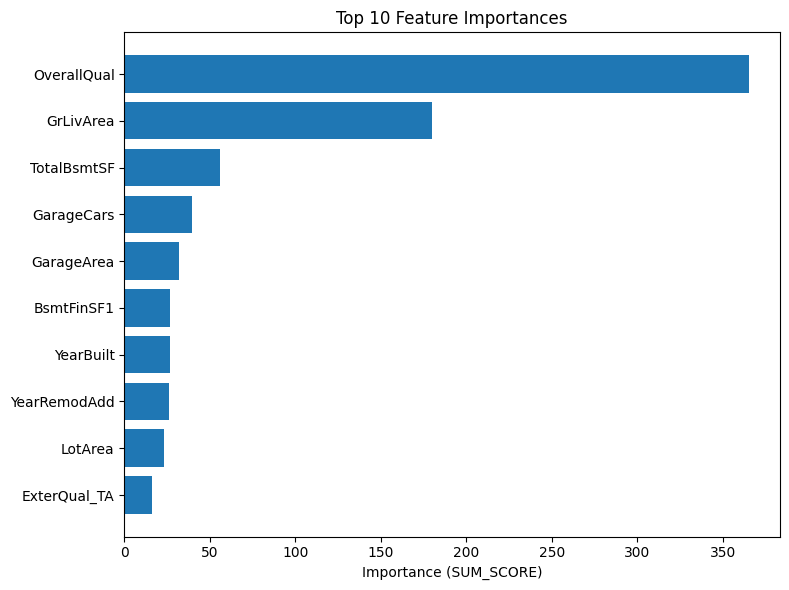

  0%|          | 0/50 [00:00<?, ?it/s]

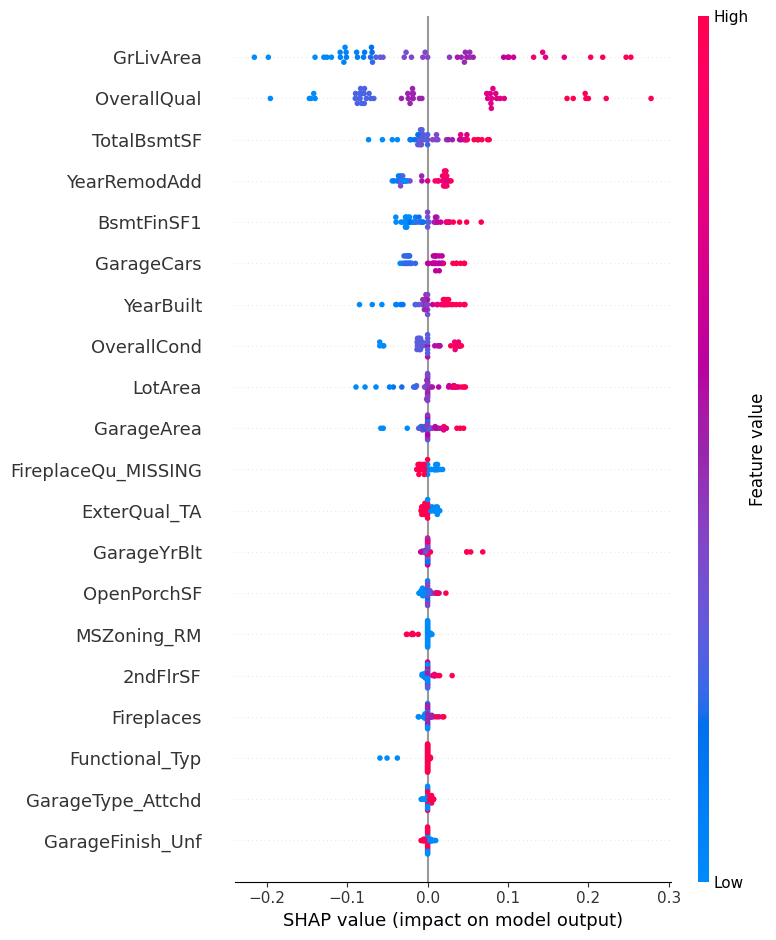

In [ ]:
if IS_INTERACTIVE:
    # Global importances
    # 1) Grab the raw (importance, feature) tuples
    importances = final_model.variable_importances()["SUM_SCORE"]
    
    # 2) Turn into a DataFrame for convenience
    df_vi = pd.DataFrame(importances, columns=["importance", "feature"])
    # If feature is a ColumnSpec, extract its name
    df_vi["feature"] = df_vi["feature"].apply(lambda f: getattr(f, "name", f))
    
    # 3) Sort and take top 10
    df_top10 = df_vi.sort_values("importance", ascending=False).head(10)
    
    # 4) Plot as a horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(df_top10["feature"][::-1], df_top10["importance"][::-1])
    plt.xlabel("Importance (SUM_SCORE)")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
    
    # SHAP summary plot
    # 1) Prepare feature matrix (no label column)
    X = df_valid_ydf.drop("SalePrice", axis=1)
    
    # 2) Select a small “background” sample to estimate expectations
    #    (too large and KernelExplainer will be *very* slow)
    background = X.sample(100, random_state=42)
    
    # 3) Wrap your model.predict function
    predict_fn = lambda data: final_model.predict(
        pd.DataFrame(data, columns=X.columns)
    )
    
    # 4) Create the explainer
    explainer = shap.KernelExplainer(predict_fn, background)
    
    # 5) Compute approximate Shapley values for a subset
    shap_vals = explainer.shap_values(X.iloc[:50], nsamples=200)
    
    # 6) Plot the summary (beeswarm) for those 50 samples
    shap.summary_plot(shap_vals, X.iloc[:50], feature_names=X.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

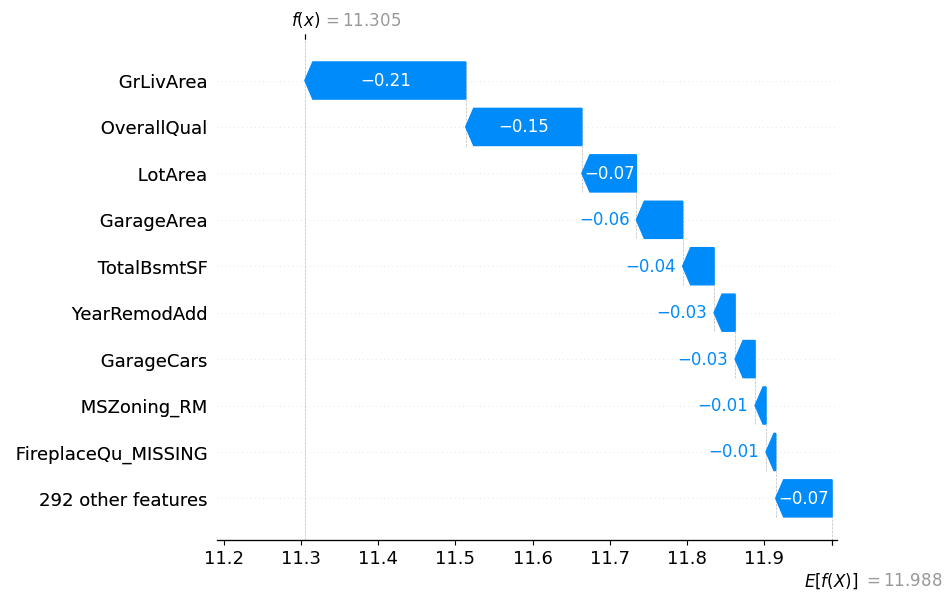

In [ ]:
if IS_INTERACTIVE:
    # Choose a single instance index to explain
    idx = 5   # the 6th house in validation set
    x_instance = X.iloc[idx:idx+1]   # keep as DataFrame
    
    # Compute SHAP values for just that one instance
    shap_vals = explainer.shap_values(x_instance, nsamples=200)
    
    # Waterfall plot (static, great for reports)
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_vals[0],
        x_instance.iloc[0],
        max_display=10
    )

# Deployment & Monitoring

> **Goal:** Put the model into production, ensure it runs reliably, and watch for drift.

* **Where** will the model live—batch pipeline, real-time API, embedded in app?
* **What** infrastructure, versioning, and CI/CD processes are needed?
* **How** will we instrument logging, performance metrics, and automated alerts?
* **What** thresholds or drift-detection methods will trigger retraining or rollback?

## Submission

Finally predict on the competition test data using the model.

In [ ]:
# Load the raw test set
df_test = pd.read_csv(base_path + "/test.csv")
test_ids = df_test["Id"]

# Preprocess exactly as done training
# Drop the Id column, keep features only
X_test = df_test.drop("Id", axis=1)

# Apply the ColumnTransformer fit earlier
# (this will do median‐impute, one‐hot, etc.)
X_test_prep = preprocessor.transform(X_test)

# Rebuild a DataFrame for YDF, with the same columns used for train
feat_names = preprocessor.get_feature_names_out()
# Remove the "num__" or "cat__" prefix so names match what YDF saw at train time
clean_names = [fn.split("__", 1)[1] for fn in feat_names]
df_test_ydf = pd.DataFrame(X_test_prep, columns=clean_names)

# Predict with your final_model
preds = np.expm1(final_model.predict(df_test_ydf))

# Build and save the submission file
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission), "rows.")

Wrote submission.csv with 1459 rows.


# Reflection & Continuous Improvement

> **Goal:** Capture lessons learned, evolve the solution, and plan for future cycles.

* **What** went well vs. what bottlenecks emerged in the workflow?
* **How** could we automate or streamline repetitive steps?
* **Which** additional data sources or techniques might boost performance?
* **What** documentation and hand-offs are needed for long-term maintainability?